<a href="https://colab.research.google.com/github/rht6226/DL/blob/main/UCI_Mobile_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the preprocessed UCI HAR Mobile dataset



In [1]:
import numpy as np
from keras.utils import to_categorical
import json
import matplotlib

In [2]:
class UciMobileDataset:
    def __init__(self, filepath):
        with np.load(filepath + 'uci.npz') as data:
            self.trainX = data['trainX']
            self.trainy = to_categorical(data['trainy'])
            self.testX = data['testX']
            self.testy = to_categorical(data['testy'])

    def summary(self):
        print("UCI Human Activity Recognition Dataset: ")
        print("Shape of training data = X:{}, y: {}".format(self.trainX.shape, self.trainy.shape))
        print("Shape of testing data = X:{}, y: {}".format(self.testX.shape, self.testy.shape))


In [3]:
uci = UciMobileDataset(filepath='/content/drive/My Drive/HAR Processed Data/UCI_HAR/')
uci.summary()

UCI Human Activity Recognition Dataset: 
Shape of training data = X:(7352, 128, 9), y: (7352, 6)
Shape of testing data = X:(2947, 128, 9), y: (2947, 6)


# 1D CNN based Model


## Model Training

In [4]:
import keras
from keras.models import Sequential, Model
from keras.layers import MaxPooling1D, Conv1D, Flatten, Dense, Concatenate, GRU, Input, Dropout, concatenate
from keras.utils.vis_utils import plot_model

In [5]:
def get_1DCNN_model(trainX, trainy, testX, testy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    # Model Definitions
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print stuff
    print(model.summary())
    return model

In [6]:
# Summarising the model Architecture

model_1D_CNN = get_1DCNN_model(uci.trainX, uci.trainy, uci.testX, uci.testy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 126, 64)           1792      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 126, 64)           4160      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 122, 64)           20544     
_________________________________________________________________
dropout (Dropout)            (None, 122, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 61, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3904)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3

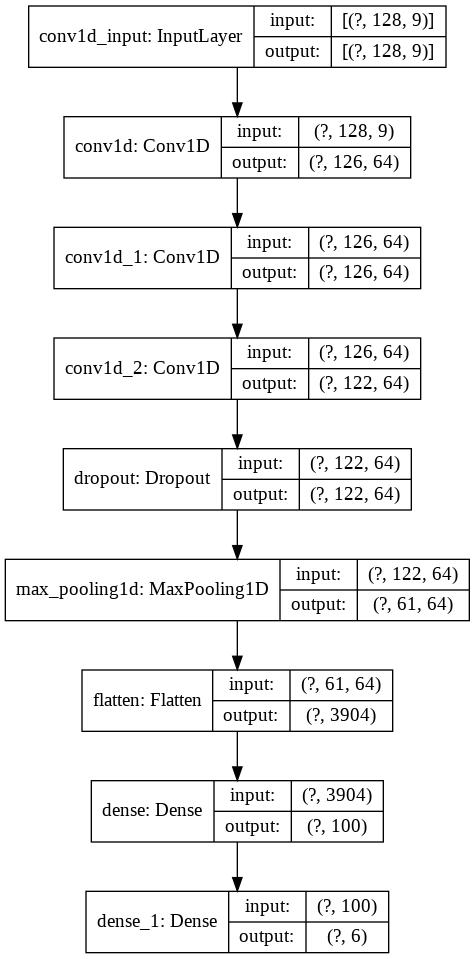

In [7]:
plot_model(model_1D_CNN, show_shapes=True, show_layer_names=True)

In [8]:
verbose, epochs, batch_size = 0, 10, 32
history_1D_CNN_UCI = model_1D_CNN.fit(uci.trainX, uci.trainy, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(uci.testX, uci.testy))

Epoch 1/10
230/230 [==============================] - 2s 7ms/step - loss: 0.3684 - accuracy: 0.8496 - val_loss: 0.4610 - val_accuracy: 0.8792
Epoch 2/10
230/230 [==============================] - 1s 4ms/step - loss: 0.1398 - accuracy: 0.9429 - val_loss: 0.3450 - val_accuracy: 0.9080
Epoch 3/10
230/230 [==============================] - 1s 4ms/step - loss: 0.1333 - accuracy: 0.9461 - val_loss: 0.3116 - val_accuracy: 0.9077
Epoch 4/10
230/230 [==============================] - 1s 4ms/step - loss: 0.1081 - accuracy: 0.9538 - val_loss: 0.2822 - val_accuracy: 0.9148
Epoch 5/10
230/230 [==============================] - 1s 4ms/step - loss: 0.1045 - accuracy: 0.9555 - val_loss: 0.3882 - val_accuracy: 0.8816
Epoch 6/10
230/230 [==============================] - 1s 4ms/step - loss: 0.1130 - accuracy: 0.9514 - val_loss: 0.3969 - val_accuracy: 0.8700
Epoch 7/10
230/230 [==============================] - 1s 4ms/step - loss: 0.0961 - accuracy: 0.9567 - val_loss: 0.3701 - val_accuracy: 0.9179
Epoch 

In [9]:
model_1D_CNN.save('/content/drive/My Drive/Colab Notebooks/Models/1DCNN_UCIHAR.h5')

In [10]:
_, accuracy = model_1D_CNN.evaluate(uci.testX, uci.testy, batch_size=batch_size, verbose=1)
print(accuracy)

93/93 [==============================] - 0s 2ms/step - loss: 0.4318 - accuracy: 0.9169
0.9168646335601807


## Plotting Accuracy


In [11]:
# Plotting Loss and Accuracy

import matplotlib.pyplot as plt

def plot_model_accuracy(details, history, figureSize=[8, 8]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy for {}'.format(details))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_model_loss(details, history, figureSize=[8, 8]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss for {}'.format(details))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

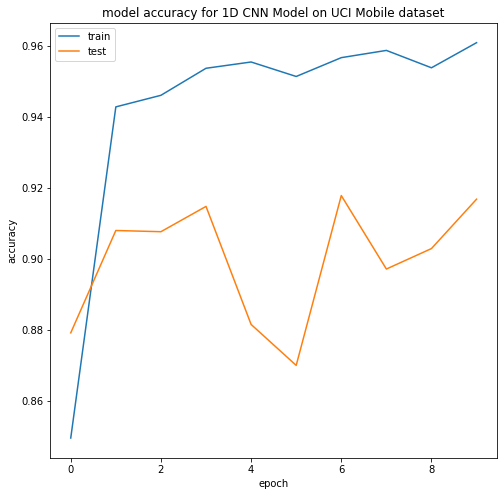

In [12]:
plot_model_accuracy("1D CNN Model on UCI Mobile dataset", history=history_1D_CNN_UCI)

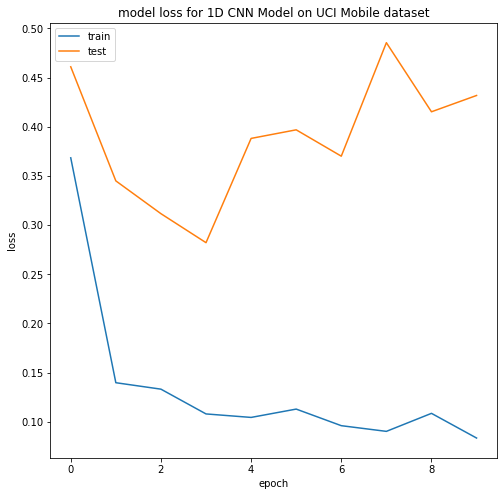

In [13]:
plot_model_loss("1D CNN Model on UCI Mobile dataset", history=history_1D_CNN_UCI)

## Plotting Confusion Matrix

In [14]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [15]:
def plot_cm(predictedY, testy, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, figureSize=[10, 10]):
    matplotlib.rcParams['figure.figsize'] = figureSize
    # Predict Y, And get Confusion Matrix
    predictedY = np.argmax(predictedY, axis = 1)
    testy = np.argmax(testy, axis=1)
    cm = confusion_matrix(y_true=testy, y_pred=predictedY)

    # Plotting
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


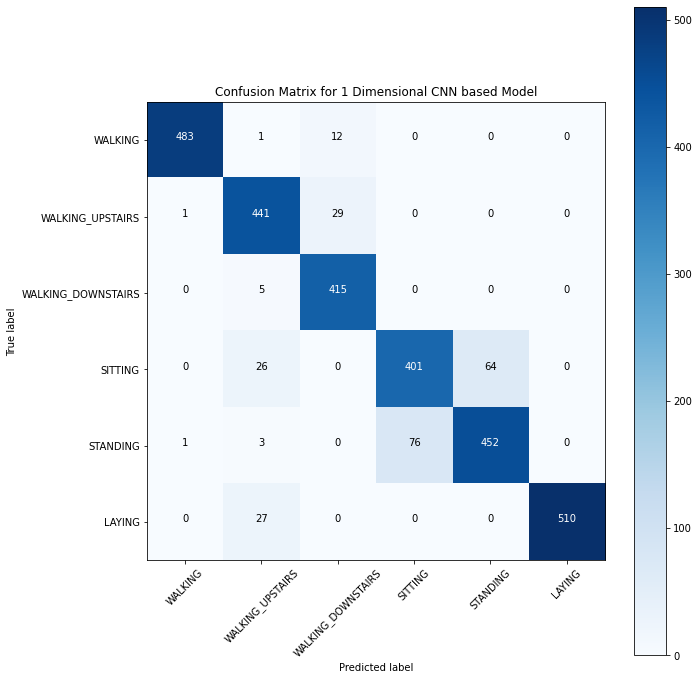

In [16]:
# CNN Based Network
predictedY = model_1D_CNN.predict(uci.testX)
cm_plot_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
plot_cm(predictedY, testy=uci.testy, classes=cm_plot_labels, title='Confusion Matrix for 1 Dimensional CNN based Model')

## Classification Report

In [17]:
from sklearn.metrics import classification_report

In [18]:
# 1D CNN based Model
predictedY = model_1D_CNN.predict(uci.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(uci.testy, axis=1)
target_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
print(classification_report(y_true, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

           WALKING       1.00      0.97      0.98       496
  WALKING_UPSTAIRS       0.88      0.94      0.91       471
WALKING_DOWNSTAIRS       0.91      0.99      0.95       420
           SITTING       0.84      0.82      0.83       491
          STANDING       0.88      0.85      0.86       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



## Overall accuracy using Weighted F-Beta Score

In [19]:
from sklearn.metrics import precision_recall_fscore_support as score

In [21]:
predictedY = model_1D_CNN.predict(uci.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(uci.testy, axis=1)

precision,recall,fscore, _ = score(y_true,y_pred,average='macro')
print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F-score   : {}'.format(fscore))


Precision : 0.9165572370615234
Recall    : 0.91903943911656
F-score   : 0.9171770105611082


# Inception Based Model

## Model Training

In [29]:
def Inception1D(input_layer, filter):
    # 1x1 Convolution
    conv_1x1 = Conv1D(filters=filter[0], kernel_size=1, activation='relu', padding='same')(input_layer)
    # 1x3 Convolution
    conv_1x3_reduce = Conv1D(filters=filter[1][0], kernel_size=1, activation='relu', padding='same')(input_layer)
    conv_1x3 = Conv1D(filters=filter[1][1], kernel_size=3, activation='relu', padding='same')(conv_1x3_reduce)
    # 1x5 Convolution
    conv_1x5_reduce = Conv1D(filters=filter[2][0], kernel_size=1, activation='relu', padding='same')(input_layer)
    conv_1x5 = Conv1D(filters=filter[2][1], kernel_size=5, activation='relu', padding='same')(conv_1x5_reduce)
    # 1x3 MaxPooling
    max_1x3 = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_layer)
    max_conv_1x1 = Conv1D(filters=filter[3], kernel_size=1, activation='relu', padding='same')(max_1x3)
    # Concat
    output = Concatenate()([conv_1x1, conv_1x3, conv_1x5, max_conv_1x1])
    
    
    return output

In [30]:
input_shape = (uci.trainX.shape[1], uci.trainX.shape[2])
output_shape = uci.trainy.shape[1]

In [31]:
def get_inception_model(input_shape, output_shape):
    ip_layer = Input(shape=input_shape)
    x = Inception1D(input_layer=ip_layer, filter=[32, (24, 64), (16, 32), 24])
    x = Inception1D(input_layer=x, filter=[48, (36, 64), (24, 48), 32])
    x = Inception1D(input_layer=x, filter=[32, (36, 64), (48, 72), 48])
    x = MaxPooling1D(pool_size=2, padding='same', strides=1)(x)
    x = Inception1D(x, [32, (24, 64), (24, 64), 24])
    x = MaxPooling1D(pool_size=2, padding='same', strides=1)(x)
    x = Flatten()(x)
    x = Dense(output_shape, activation='softmax')(x)

    model = Model(ip_layer, x, name='inception_HAR')

    return model

In [32]:
input_shape = (uci.trainX.shape[1], uci.trainX.shape[2])
output_shape = uci.trainy.shape[1]

model = get_inception_model(input_shape, output_shape)
model.summary()

Model: "inception_HAR"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 128, 24)      240         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 128, 16)      160         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 128, 9)       0           input_2[0][0]                    
______________________________________________________________________________________

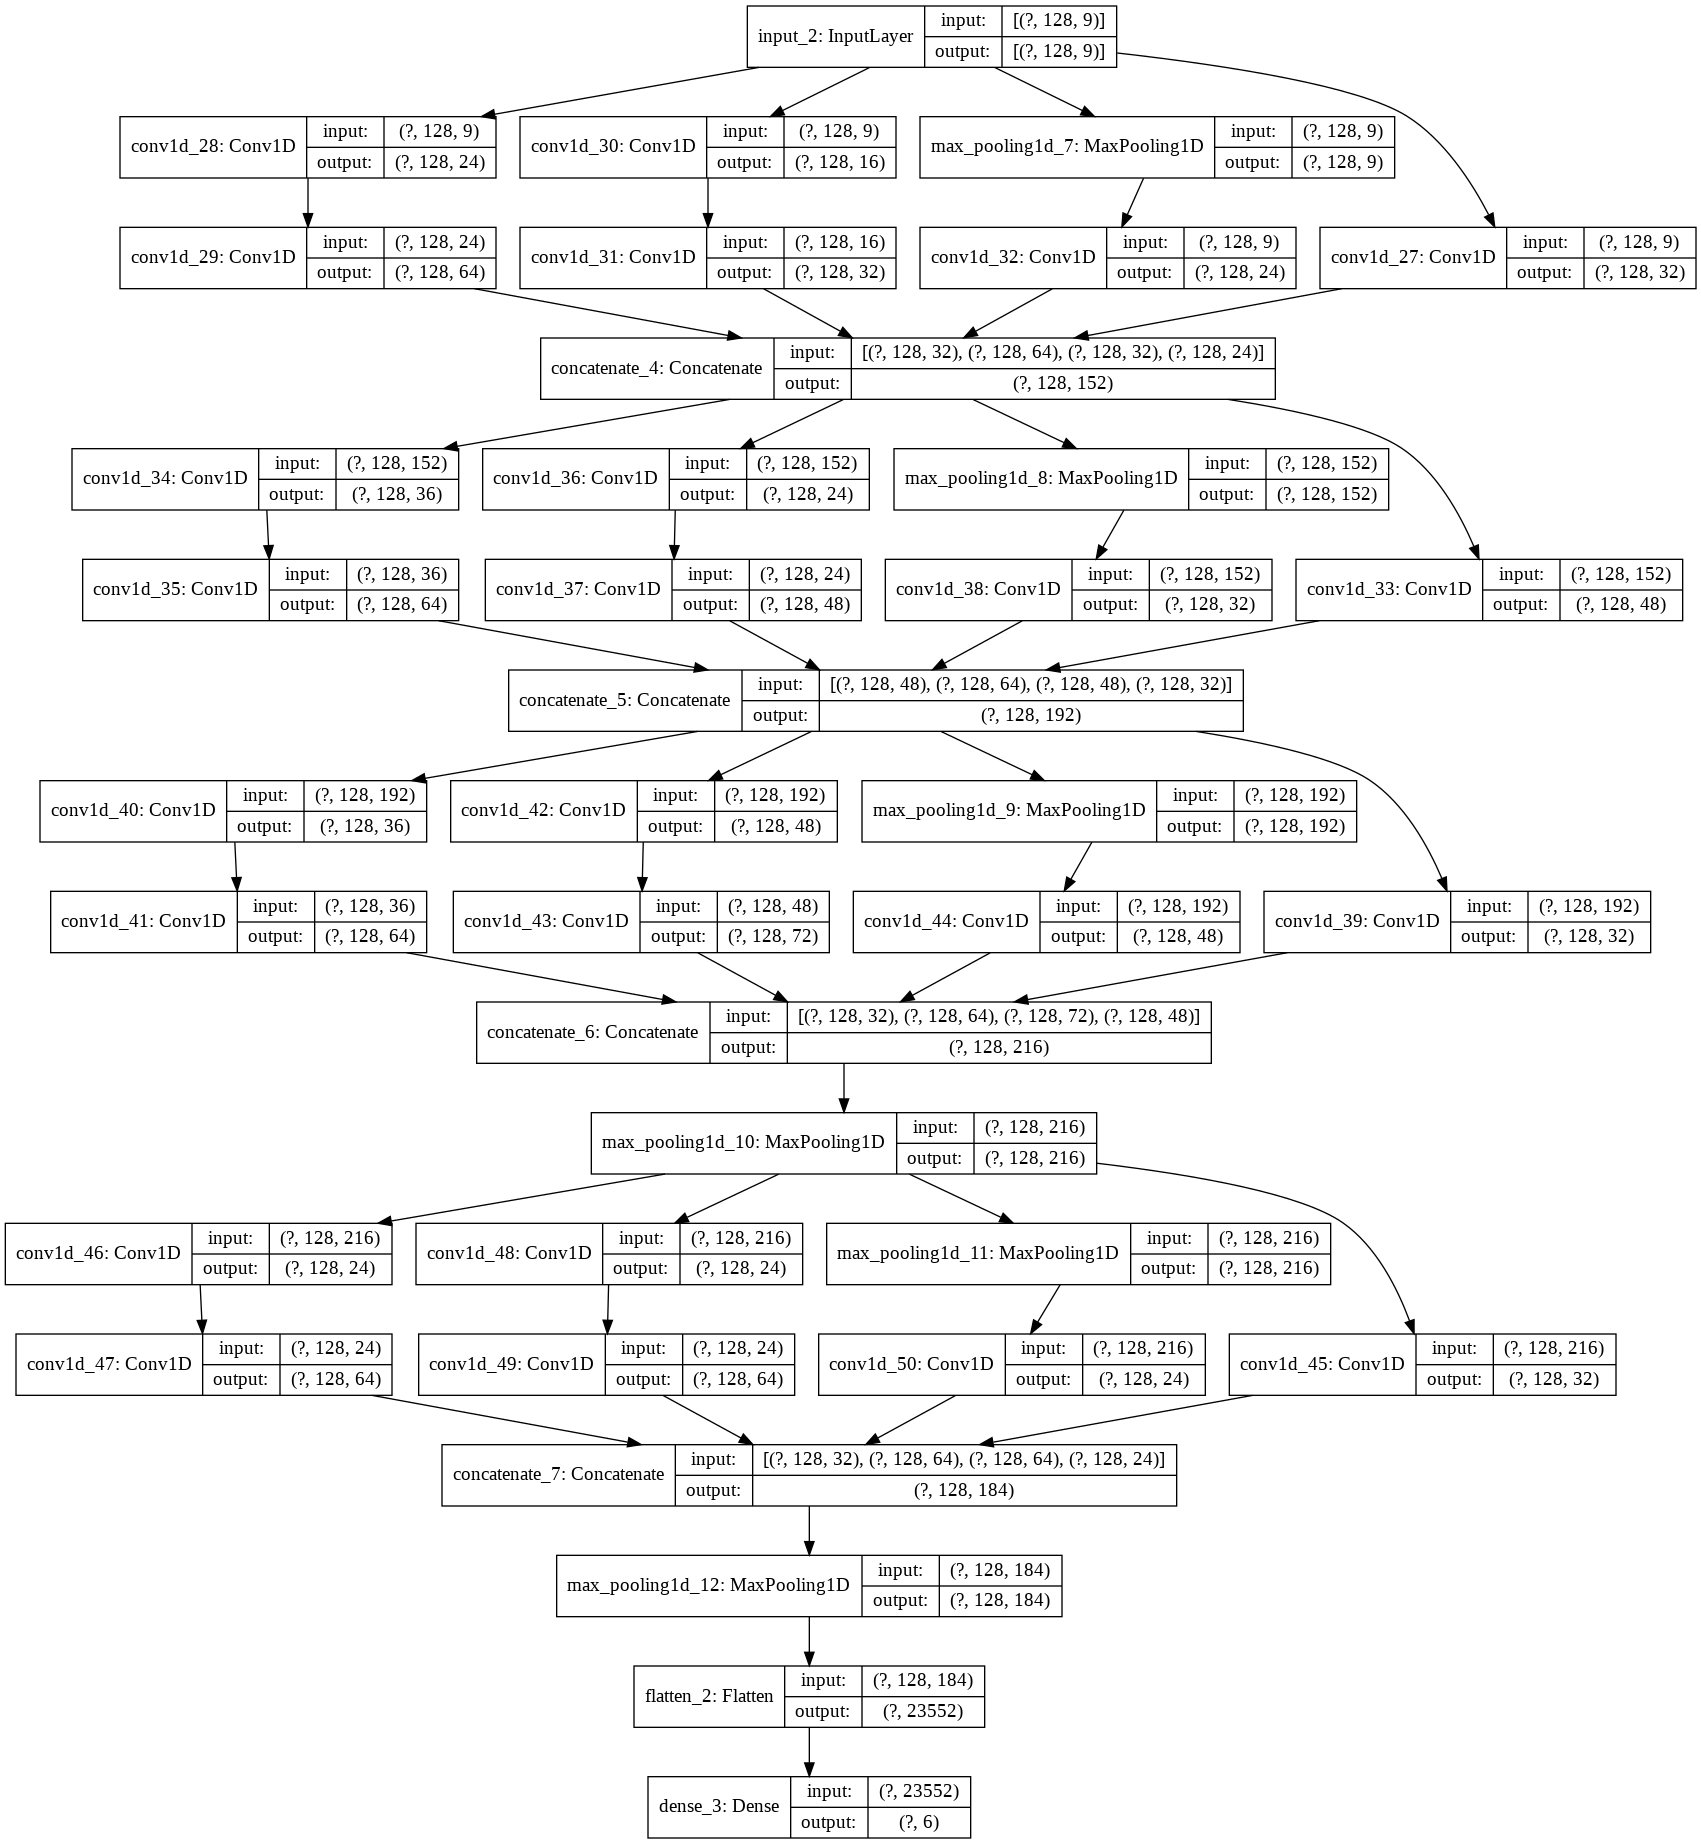

In [33]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=False)

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
history_inception = model.fit(x=uci.trainX, y=uci.trainy, validation_data=(uci.testX, uci.testy), verbose=1, batch_size=64, epochs=12)

Epoch 1/12
115/115 [==============================] - 7s 58ms/step - loss: 0.4516 - accuracy: 0.8128 - val_loss: 0.3451 - val_accuracy: 0.8711
Epoch 2/12
115/115 [==============================] - 3s 24ms/step - loss: 0.1359 - accuracy: 0.9429 - val_loss: 0.3101 - val_accuracy: 0.8968
Epoch 3/12
115/115 [==============================] - 3s 24ms/step - loss: 0.1142 - accuracy: 0.9484 - val_loss: 0.3831 - val_accuracy: 0.9013
Epoch 4/12
115/115 [==============================] - 3s 24ms/step - loss: 0.1026 - accuracy: 0.9525 - val_loss: 0.3709 - val_accuracy: 0.8992
Epoch 5/12
115/115 [==============================] - 3s 24ms/step - loss: 0.1360 - accuracy: 0.9440 - val_loss: 0.3486 - val_accuracy: 0.9043
Epoch 6/12
115/115 [==============================] - 3s 23ms/step - loss: 0.0937 - accuracy: 0.9588 - val_loss: 0.3402 - val_accuracy: 0.9135
Epoch 7/12
115/115 [==============================] - 3s 24ms/step - loss: 0.0930 - accuracy: 0.9559 - val_loss: 0.2923 - val_accuracy: 0.9209

In [36]:
model_1D_CNN.save('/content/drive/My Drive/Colab Notebooks/Models/inception_UCIHAR.h5')

In [37]:
_, accuracy = model.evaluate(uci.testX, uci.testy, batch_size=batch_size, verbose=1)
print(accuracy)

93/93 [==============================] - 1s 6ms/step - loss: 0.4160 - accuracy: 0.9206
0.9205971956253052


## Plotting Accuracy

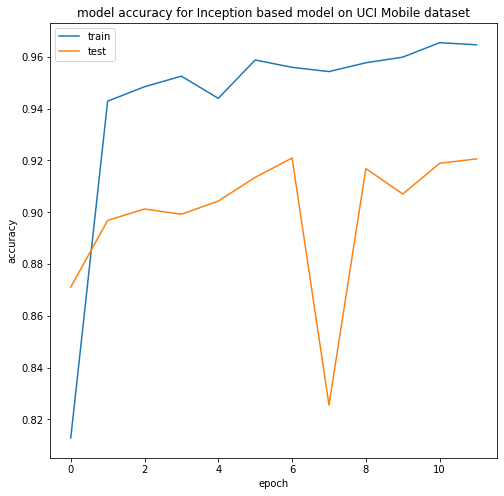

In [39]:
plot_model_accuracy("Inception based model on UCI Mobile dataset", history=history_inception)

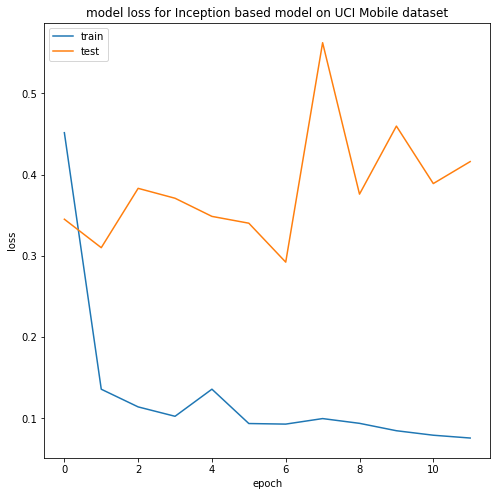

In [40]:
plot_model_loss("Inception based model on UCI Mobile dataset", history=history_inception)

## Plotting Confusion Matrix



Confusion matrix, without normalization


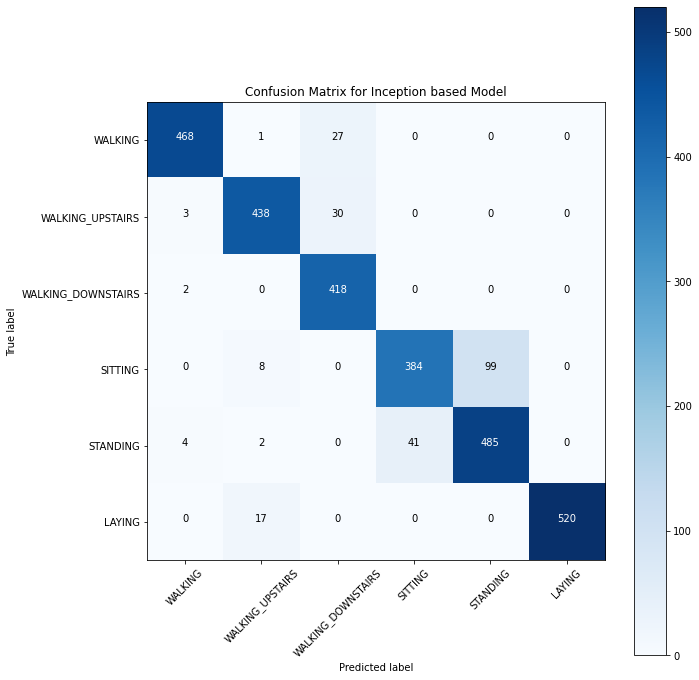

In [42]:
# Inception Based Network
predictedY = model.predict(uci.testX)
plot_cm(predictedY, testy=uci.testy, classes=cm_plot_labels, title='Confusion Matrix for Inception based Model')

## Classification Reports

In [43]:
from sklearn.metrics import classification_report

In [46]:
# Inception Based Model

predictedY = model.predict(uci.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(uci.testy, axis=1)
target_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
print(classification_report(y_true, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

           WALKING       0.98      0.94      0.96       496
  WALKING_UPSTAIRS       0.94      0.93      0.93       471
WALKING_DOWNSTAIRS       0.88      1.00      0.93       420
           SITTING       0.90      0.78      0.84       491
          STANDING       0.83      0.91      0.87       532
            LAYING       1.00      0.97      0.98       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



## Overall accuracy using Weighted F-Beta Score

In [47]:
 predictedY = model.predict(uci.testX)
y_pred = np.argmax(predictedY, axis = 1)
y_true = np.argmax(uci.testy, axis=1)

precision,recall,fscore, _ = score(y_true,y_pred,average='macro')
print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F-score   : {}'.format(fscore))


Precision : 0.9225091837302212
Recall    : 0.9217994934668923
F-score   : 0.9204117372914121
